# Make of a neural network with numpy

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/tmp/ipykernel_6070/2080034654.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Using ndarrays as Tensors, adding the typing library to be more explicit and creating a new type "Func" which is a function taking a Tensor as argument and returning a Tensor

In [2]:
from numpy import ndarray as Tensor

from typing import (Dict, Tuple, Callable, 
                    Sequence, Iterator, NamedTuple)
Func = Callable[[Tensor], Tensor]

### Defining the Loss function to minimize

In [3]:
# Class constructiong a generic loss function

class Loss:
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        """ 
        Compute the loss between predictions and actual labels 
        """
        raise NotImplementedError

    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        """ 
        Compute the gradient for the backward pass 
        """
        raise NotImplementedError

# Mean square error loss

class MeanSquareError(Loss):
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        return np.sum((predicted - actual)**2) / len(actual)
    
    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return (2 * (predicted - actual)) / len(actual)
    
# Binary cross entropy loss

class BinCrossEntropy(Loss):
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        return - ((np.sum(actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted))) / len(actual))
    
    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return - (((actual / predicted) - ((1 - actual) / (1 - predicted))) / len(actual))


### Constructring the different layers with classes

In [4]:
# Class constructing a generic layer

class Layer:
    def __init__(self) -> None:

        # Store the parameters values and gradients in dictionnaries
        self.params: Dict[str, Tensor] = {}
        self.grads: Dict[str, Tensor] = {}

    def forward(self, inputs: Tensor) -> Tensor:
        raise NotImplementedError

    def backward(self, grad: Tensor) -> Tensor:
        raise NotImplementedError


# Class constructing a linear layer of neurons

class Linear(Layer):
    """
    Inputs are of size (batch_size, input_size)
    Outputs are of size (batch_size, output_size)
    """
    def __init__(self, input_size: int, output_size: int, Seed: bool = False) -> None:
    
        # Inherit from base class Layer
        super().__init__()
        
        # Initialize the weights and bias with random values
        if Seed == True:
            np.random.seed(4)

        self.params["w"] = np.random.randn(input_size, output_size)
        self.params["b"] = np.random.randn(output_size)

    def forward(self, inputs: Tensor) -> Tensor:
        """
        inputs shape is (batch_size, input_size)
        """
        self.inputs = inputs

        # Compute the feed forward pass
        # (b,i) @ (i,o) + (1,o) = (b,o)
        return inputs @ self.params["w"] + self.params["b"]
        
         
    def backward(self, grad: Tensor) -> Tensor:
        """
        grad shape is (batch_size, output_size)
        """
        # Compute the gradient parameters for the layer
        # (i,b) @ (b,o) = (i,o)
        self.grads["w"] =  np.transpose(self.inputs) @ grad
        self.grads["b"] = grad #(b,o)
    
        # Compute the feed backward pass
        # (b,o) @ (o,i) = (b,i)
        return grad @ np.transpose(self.params["w"])


#Defining possible activation functions

def tanh(x: Tensor) -> Tensor:
    return np.tanh(x)

def tanh_prime(x: Tensor) -> Tensor:
    return 1 - (np.tanh(x))**2

def sigmoid(x: Tensor) -> Tensor:
    return 1/(1 + np.exp(-x))

def sigmoid_prime(x: Tensor) -> Tensor:
    return sigmoid(x)*(1 - sigmoid(x))


# Class constructing an activation layer

class Activation(Layer):
    """
    An activation layer just applies a function
    elementwise to its inputs
    """
    def __init__(self, f: Func, f_prime: Func) -> None:
        super().__init__()
        self.f = f
        self.f_prime = f_prime

    def forward(self, inputs: Tensor) -> Tensor:
        self.inputs = inputs
        return self.f(inputs)

    def backward(self, grad: Tensor) -> Tensor:
        return self.f_prime(self.inputs) * grad
    
    

### Class constructing the network, doing the full forward and backward pass and optimizing the parameters

In [5]:
class NeuralNet:
    def __init__(self, layers: Sequence[Layer], lr: float = 0.01) -> None:
        self.layers = layers
        # Learning rate
        self.lr = lr 
        
    def forward(self, inputs: Tensor) -> Tensor:
        """
        The forward pass takes the layers in order
        """
        for layer in self.layers:
            inputs = layer.forward(inputs)
        return inputs

    def backward(self, grad: Tensor) -> Tensor:
        """
        The backward pass is the other way around
        """
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad
    
    def optimize(self) -> None:
        """
        Optimize the paramaters value at each step
        """
        for layer in self.layers:
            for name in layer.params.keys():
                layer.params[name] = layer.params[name] - self.lr * layer.grads[name]

### Class defining how to organize the data in series of batch

In [6]:
Batch = NamedTuple("Batch", [("inputs", Tensor), ("targets", Tensor)])
        
class BatchIterator:
    """ 
    Organize the data in batch that are shuffled at each epoch
    """
    def __init__(self, batch_size: int = 32, shuffle: bool = True) -> None:
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __call__(self, inputs: Tensor, targets: Tensor) -> Iterator[Batch]:
        """ 
        Create batch iteratively and yields them one after the other
        """
        starts = np.arange(0, len(inputs), self.batch_size)
        if self.shuffle:
            np.random.shuffle(starts)

        for start in starts:
            end = start + self.batch_size
            batch_inputs = inputs[start:end]
            batch_targets = targets[start:end]
            yield Batch(batch_inputs, batch_targets)

### Defining the training routine of the network

In [7]:
def train(net: NeuralNet, inputs: Tensor, targets: Tensor,
        loss: Loss = MeanSquareError(),
        iterator = BatchIterator(),
        num_epochs: int = 5000,
        Print: bool = True) -> Tuple:
    """
    Train the network in series of batch
    and for a number of epochs
    Compute the evolution of the loss and accuracy
    """

    Loss_list : Sequence = []
    Acc_list : Sequence = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0

        # Lists to store the predicted and actual labels 
        # in the right order, at each epoch
        Predicted_list: Sequence = []
        Actual_list: Sequence = [] 

        for batch in iterator(inputs, targets):

            Batch_loss : Sequence = []
            Batch_grad : Sequence = []

            predicted = net.forward(batch[0])
            for p in predicted:
                Predicted_list.append(p)
            for a in batch[1]:
                Actual_list.append(a)
                
            Batch_loss.append(loss.loss(predicted, batch[1]))
            grad = loss.grad(predicted, batch[1])
            Batch_grad.append(grad) 
            net.backward(grad)
            net.optimize()


        Predicted_array = np.array(Predicted_list)
        Actual_array = np.array(Actual_list)   

        # Compute the loss as the mean of batch loss    
        epoch_loss = np.mean(Batch_loss)
        # Compare all the labels for the epoch
        epoch_acc = np.mean(Predicted_array.round()==Actual_array) * 100

        Loss_list.append(epoch_loss)
        Acc_list.append(epoch_acc)
                    
        # Print status every 100 iterations
        if Print == True:
            if epoch % 100 == 0:
                print("Epoch = ", epoch, " Loss = ", epoch_loss," Acc = ", epoch_acc)

    return (Loss_list, Acc_list, Actual_array, Predicted_array)
        
    # print("Targets - Predictions - Results")
    # for y, z in zip(Actual_array, Predicted_array):
    #     print(f'{y} => {z} => {z.round()}')

### Validation Process

In [8]:
def validate(net: NeuralNet, inputs: Tensor, targets: Tensor,
        loss: Loss = MeanSquareError(),
        iterator = BatchIterator(), 
        Print: bool = True) -> Tuple:
    """
    Compute the accuracy and loss of the network 
    on another dataset (not seen in train)
    """

    # Lists to store the predicted and actual labels 
    # in the right order   
    Predicted_list: Sequence =[] 
    Actual_list: Sequence = [] 
    
    for batch in iterator(inputs, targets):

        Batch_loss : Sequence = [] 

        predicted = net.forward(batch[0])
        for p in predicted:
            Predicted_list.append(p)
        for a in batch[1]:
            Actual_list.append(a)

        Batch_loss.append(loss.loss(predicted, batch[1]))   
    
    Predicted_array = np.array(Predicted_list)
    Actual_array = np.array(Actual_list)

    # Compute the loss as the mean of batch loss     
    val_loss = np.mean(Batch_loss)
    # Compare all the labels
    val_acc = np.mean(Predicted_array.round()==Actual_array) * 100

    if Print == True:
        print("## Validation ##\n", "Loss = ", val_loss," Acc = ", val_acc)

    return (val_loss, val_acc, Actual_array, Predicted_array)

### Extracting the data from the dataset

In [9]:
# Number of data points / events taken from the dataset 
# For Training
lines_train: int = 2000
# For Validation
lines_val: int = 2000

# 2 types of dataset with different variables
dataset1_train = pd.read_csv('dataset_modif2.csv', usecols=np.arange(0,12), nrows=lines_train)
dataset2_train = pd.read_csv('dataset_modif2.csv', usecols=[1, 2, 3], nrows=lines_train)

dataset1_val = pd.read_csv('dataset_modif2.csv', usecols=np.arange(0,12), skiprows=lines_train+1, nrows=lines_val)
dataset2_val = pd.read_csv('dataset_modif2.csv', usecols=[1, 2, 3], skiprows=lines_train+1, nrows=lines_val)


labels_train = pd.read_csv('dataset_modif2.csv', usecols=["label"], nrows=lines_train)
labels_val = pd.read_csv('dataset_modif2.csv', usecols=[13], skiprows=lines_train+1, nrows=lines_val)

# New labels for binary calssification
# 0 -> 1 and 1,2 -> 0
bin_labels_train = np.where(labels_train.values == 0, 1, 0)
bin_labels_val = np.where(labels_val.values == 0, 1, 0)


In [10]:
seed_value: bool = True
batch_num: int = 200

NetCE = NeuralNet([
    Linear(input_size=12, output_size=4, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=4, output_size=6, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=6, output_size=6, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=6, output_size=4, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=4, output_size=1, Seed=seed_value),
    Activation(sigmoid, sigmoid_prime),
])

NetMSE = NeuralNet([
    Linear(input_size=12, output_size=4, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=4, output_size=6, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=6, output_size=6, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=6, output_size=4, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=4, output_size=1, Seed=seed_value),
    Activation(sigmoid, sigmoid_prime),
])


In [11]:
NetCE_Loss_train, NetCE_Acc_train, NetCE_Actual_train, NetCE_Pred_train = train(NetCE, inputs=dataset1_train.values, targets=bin_labels_train, 
                                                                            loss=BinCrossEntropy(), iterator=BatchIterator(batch_size=batch_num), num_epochs=5000)

NetCE_Loss_val, NetCE_Acc_val, NetCE_Actual_val, NetCE_Pred_val = validate(NetCE, inputs=dataset1_val.values, targets=bin_labels_val, 
                                                                       loss=BinCrossEntropy(), iterator=BatchIterator(batch_size=batch_num))

Epoch =  0  Loss =  0.6614529915354421  Acc =  63.449999999999996
Epoch =  100  Loss =  0.3083644040918702  Acc =  88.25
Epoch =  200  Loss =  0.27894203230606895  Acc =  91.14999999999999
Epoch =  300  Loss =  0.22524108653142208  Acc =  92.35
Epoch =  400  Loss =  0.18234883898713214  Acc =  93.2
Epoch =  500  Loss =  0.203689221475426  Acc =  93.8
Epoch =  600  Loss =  0.17197185204905246  Acc =  94.45
Epoch =  700  Loss =  0.1542126935636579  Acc =  94.75
Epoch =  800  Loss =  0.13875557698499277  Acc =  95.1
Epoch =  900  Loss =  0.18884406069708404  Acc =  95.0
Epoch =  1000  Loss =  0.12224479789926976  Acc =  95.15
Epoch =  1100  Loss =  0.1004876434745383  Acc =  95.8
Epoch =  1200  Loss =  0.10671800197668478  Acc =  95.85000000000001
Epoch =  1300  Loss =  0.1538844086909403  Acc =  95.8
Epoch =  1400  Loss =  0.15529719118664562  Acc =  95.95
Epoch =  1500  Loss =  0.09521630184104601  Acc =  96.0
Epoch =  1600  Loss =  0.08051432256905545  Acc =  96.1
Epoch =  1700  Loss =

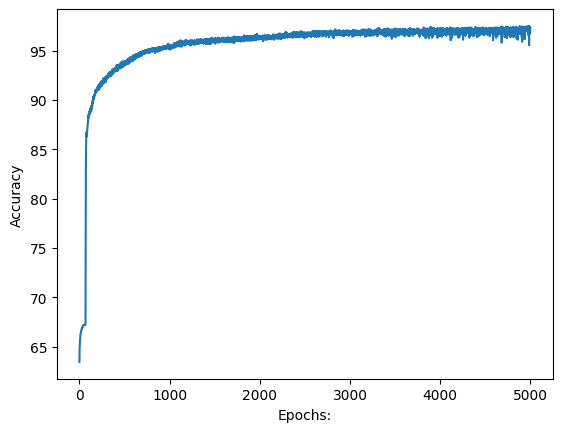

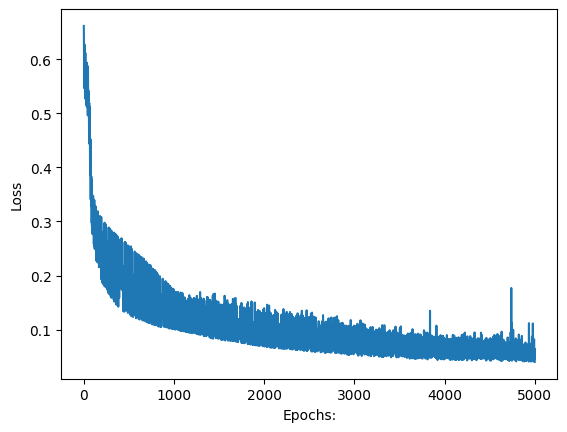

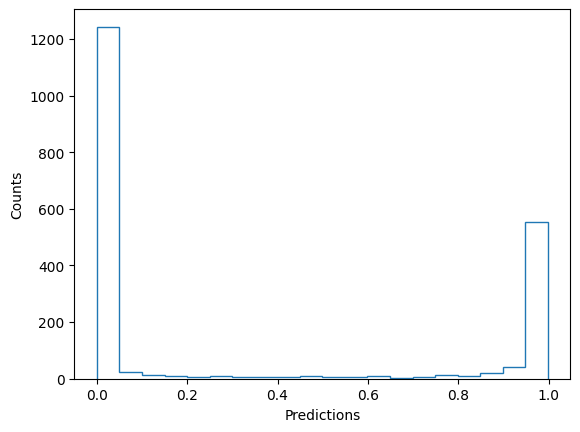

In [12]:
plt.plot(NetCE_Acc_train)
plt.ylabel('Accuracy')
plt.xlabel("Epochs:")
plt.show()
    
plt.plot(NetCE_Loss_train)
plt.ylabel('Loss')
plt.xlabel("Epochs:")
plt.show()

plt.hist(NetCE_Pred_val, histtype='step', bins=20)
plt.xlabel("Predictions")
plt.ylabel("Counts")
plt.show()

In [13]:
NetMSE_Loss_train, NetMSE_Acc_train, NetMSE_Actual_train, NetMSE_Pred_train = train(NetMSE, inputs=dataset1_train.values, targets=bin_labels_train,
                                                                            loss=MeanSquareError(), iterator=BatchIterator(batch_size=batch_num), num_epochs=5000)

NetMSE_Loss_val, NetMSE_Acc_val, NetMSE_Actual_val, NetMSE_Pred_val = validate(NetMSE, inputs=dataset1_val.values, targets=bin_labels_val,
                                                                       loss=MeanSquareError(), iterator=BatchIterator(batch_size=batch_num))

Epoch =  0  Loss =  0.23330127149313692  Acc =  63.3
Epoch =  100  Loss =  0.16993076677932273  Acc =  67.2
Epoch =  200  Loss =  0.10411607615089437  Acc =  87.25
Epoch =  300  Loss =  0.07680078962007761  Acc =  89.25
Epoch =  400  Loss =  0.06219703503061957  Acc =  90.7
Epoch =  500  Loss =  0.07667295967963204  Acc =  91.3
Epoch =  600  Loss =  0.05709933511760973  Acc =  91.8
Epoch =  700  Loss =  0.059595202430230164  Acc =  92.10000000000001
Epoch =  800  Loss =  0.05592198048834987  Acc =  92.7
Epoch =  900  Loss =  0.053519643041813565  Acc =  92.9
Epoch =  1000  Loss =  0.08563469673227614  Acc =  93.15
Epoch =  1100  Loss =  0.06637334151231043  Acc =  93.45
Epoch =  1200  Loss =  0.044281175415583594  Acc =  93.55
Epoch =  1300  Loss =  0.06327560933252595  Acc =  93.8
Epoch =  1400  Loss =  0.03756308885645317  Acc =  94.0
Epoch =  1500  Loss =  0.059324448122107805  Acc =  94.19999999999999
Epoch =  1600  Loss =  0.05800601507663036  Acc =  94.39999999999999
Epoch =  170

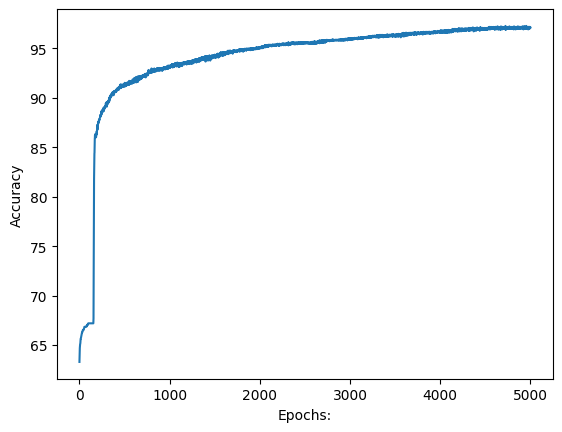

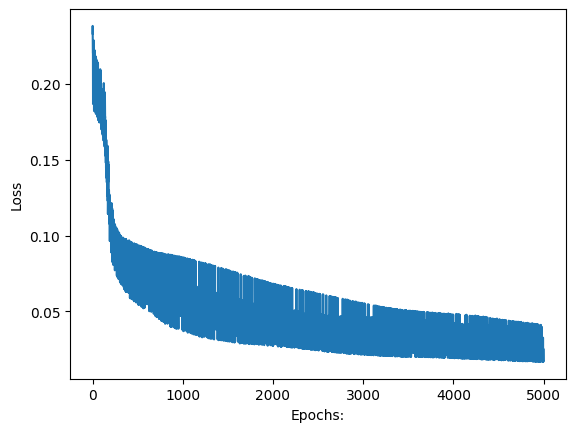

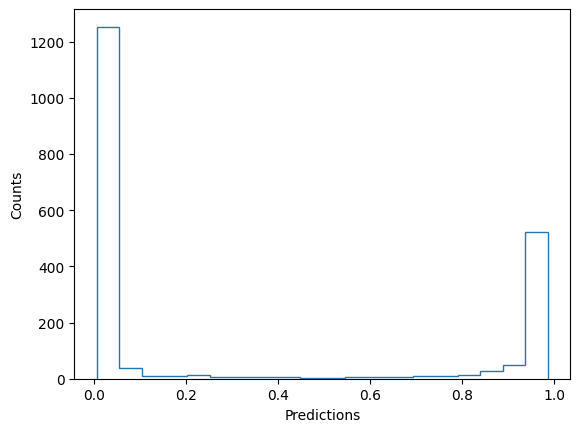

In [14]:
plt.plot(NetMSE_Acc_train)
plt.ylabel('Accuracy')
plt.xlabel("Epochs:")
plt.show()
    
plt.plot(NetMSE_Loss_train)
plt.ylabel('Loss')
plt.xlabel("Epochs:")
plt.show()

plt.hist(NetMSE_Pred_val, histtype='step', bins=20)
plt.xlabel("Predictions")
plt.ylabel("Counts")
plt.show()

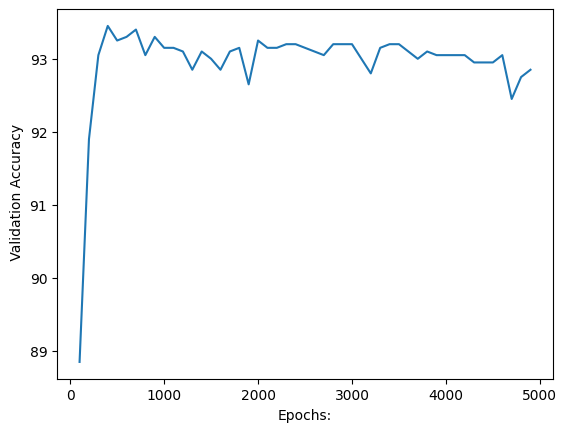

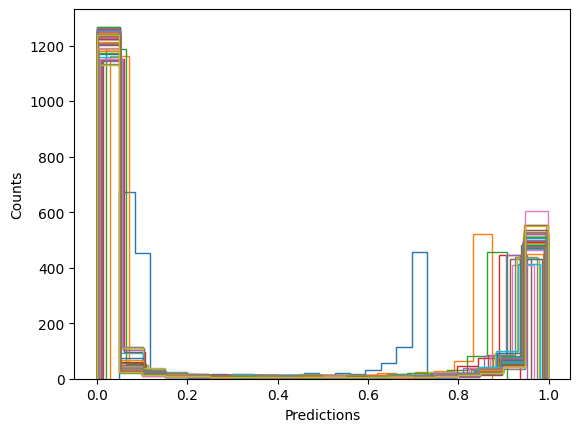

In [15]:
epoch_range = np.arange(100, 5000, 100)

Acc_tot: Sequence = []
Loss_tot: Sequence = []
Pred_tot: Sequence = []

for N in epoch_range:

    net = NeuralNet([
        Linear(input_size=12, output_size=4, Seed=seed_value),
        Activation(tanh, tanh_prime),
        Linear(input_size=4, output_size=6, Seed=seed_value),
        Activation(tanh, tanh_prime),
        Linear(input_size=6, output_size=6, Seed=seed_value),
        Activation(tanh, tanh_prime),
        Linear(input_size=6, output_size=4, Seed=seed_value),
        Activation(tanh, tanh_prime),
        Linear(input_size=4, output_size=1, Seed=seed_value),
        Activation(sigmoid, sigmoid_prime),
    ])

    train(net, inputs=dataset1_train.values, targets=bin_labels_train,
          loss=BinCrossEntropy(), iterator=BatchIterator(batch_size=batch_num), num_epochs=N, Print=False)

    net_Loss_val, net_Acc_val, net_Actual_val, net_Pred_val = validate(net, inputs=dataset1_val.values, targets=bin_labels_val, 
                                                                        loss=BinCrossEntropy(), iterator=BatchIterator(batch_size=batch_num), Print=False)
    
    Acc_tot.append(net_Acc_val)
    Loss_tot.append(net_Loss_val)
    Pred_tot.append(net_Pred_val)
    

plt.plot(epoch_range, Acc_tot)
plt.ylabel(' Validation Accuracy')
plt.xlabel("Epochs:")
plt.show()

for p in Pred_tot:
    plt.hist(p, histtype='step', bins=20)
    plt.xlabel("Predictions")
    plt.ylabel("Counts")
plt.show()
